**Кратий план работы:**

**Анализ результатов A/B-теста крупного интернет-магазина:**

1. Открыть файл и посмотреть информацию, посмотреть наличие пропусков и дубликатов, зафиксировать начальные данные.
2. Заменить названия столбоцов, обработать пропуски, преобразовать типы столбцов.
3. Применить фреймоврки `ICE` и `RICE` для приоритизации гипотез.
4. Произвести исследовательский анализ A/B теста.
5. Построить графики и сделать подсчёт 95-й и 99-й перцентили .
6. Посчитать статистическую значимость, сделать выводы и предположения.
7. По результатам теста принять решение о продолжения теста или остановки
8. Написать промежуточные и общий вывод.
9. **Цель исследования:** По результатам А/B теста принять решение о продолжении теста.
10. Метрики для А/B тестирования:
- увеличиние среднего чека - проверить средний чек в группе А или В в результате тестирования
- повышение конверсии - изменилась ли конверсия по результатам А/B теста
- количество заказов - как поменялось количество заказов во время А/B тестирования

# Шаг №1 Приоритизация гипотез

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import datetime as dt

In [2]:
# Настройка ширины столбца
pd.options.display.max_colwidth = 120

In [3]:
#open file
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
    
except:
    hypothesis_url = 'https://drive.google.com/file/d/1Dqmy1XHGyznW7YRRDDkMU5VSY1Xqkm4I/view?usp=drive_link'
    hypothesis_path = 'https://drive.google.com/uc?export=download&id='+hypothesis_url.split('/')[-2]
    hypothesis = pd.read_csv(hypothesis_path)
    
    orders_url = 'https://drive.google.com/file/d/1GLzJ0mgsz3GxFIoamKDkMckR-NLeewzq/view?usp=drive_link'
    orders_path = 'https://drive.google.com/uc?export=download&id='+orders_url.split('/')[-2]
    orders = pd.read_csv(orders_path, parse_dates=['date'])

    visitors_url = 'https://drive.google.com/file/d/1HGChtTcDA87-IvEczvb8W5UasayOMhhv/view?usp=sharing'
    visitors_path = 'https://drive.google.com/uc?export=download&id='+visitors_url.split('/')[-2]
    visitors = pd.read_csv(visitors_path, parse_dates=['date'])

In [4]:
# Функция для просмотра информации о DataFrame
def info_data_frame (x):
    return  display(
        print('------Информация о DataFrame------\n'),
        x.info(),
        '-'* 25,           
        'Вывод первых 5 строчек:', x.head(),           
        f'Число строк : {x.shape[0]}',
        '-'* 25,
        f'Число столбцов : {x.shape[1]}',
        '-'* 25,
        f'Количество дубликатов = {x.duplicated().sum()}',
        '-'* 25,
        'Пропущенные значения:',  x.isna().sum(),
        '-'* 25,            
        'Процент пропусков от всего DataFrame:',
         (x.isna().mean().sort_values(ascending=False)*100).astype(str) + '%'
        )               

In [5]:
info_data_frame(hypothesis)

------Информация о DataFrame------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

None

'-------------------------'

'Вывод первых 5 строчек:'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


'Число строк : 9'

'-------------------------'

'Число столбцов : 5'

'-------------------------'

'Количество дубликатов = 0'

'-------------------------'

'Пропущенные значения:'

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

'-------------------------'

'Процент пропусков от всего DataFrame:'

Hypothesis    0.0%
Reach         0.0%
Impact        0.0%
Confidence    0.0%
Efforts       0.0%
dtype: object

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   
    
DataFrame нужно привести к нижнему регистру 
</div>

In [6]:
# Приведение названия столбцов к нижнему регистру
hypothesis.columns =  hypothesis.columns.str.lower().str.replace(' ', '_')

In [7]:
info_data_frame(orders)

------Информация о DataFrame------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

None

'-------------------------'

'Вывод первых 5 строчек:'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


'Число строк : 1197'

'-------------------------'

'Число столбцов : 5'

'-------------------------'

'Количество дубликатов = 0'

'-------------------------'

'Пропущенные значения:'

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

'-------------------------'

'Процент пропусков от всего DataFrame:'

transactionId    0.0%
visitorId        0.0%
date             0.0%
revenue          0.0%
group            0.0%
dtype: object

In [8]:
info_data_frame(visitors)

------Информация о DataFrame------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

None

'-------------------------'

'Вывод первых 5 строчек:'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


'Число строк : 62'

'-------------------------'

'Число столбцов : 3'

'-------------------------'

'Количество дубликатов = 0'

'-------------------------'

'Пропущенные значения:'

date        0
group       0
visitors    0
dtype: int64

'-------------------------'

'Процент пропусков от всего DataFrame:'

date        0.0%
group       0.0%
visitors    0.0%
dtype: object

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   

**Вывод по разделу:** 
1. Открыты 3 DataFrame **`hypothesis, orders, visitors`**, дубликаты и пропуски не обнаружены, столбцы приведены к нижнему регистру, столбцы с датами приведены к к типу datetime64[ns].
</div>

## Применим фреймворк `ICE` для приоритизации гипотез.

In [9]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [10]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'],2)

In [11]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   
    
Как видно из данных, наиболее перспективные гипотезы:
    
- `8 - Запустить акцию, дающую скидку на товар в день рождения`
- `0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`
- `7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`
- `6 -`Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`
- `2 -`Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`   
    
</div>

## Применим фреймворк `RICE` для приоритизации гипотез.

In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [13]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   
    
<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   
    
Фреймворк RICE поменял приоритеты по гипотезам: 
- `7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`
- `2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`
- `0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`
- `6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`
- `8 - Запустить акцию, дающую скидку на товар в день рождения`     
    теперь на первом месте не `запустить акцию, дающую скидку на товар в день рождения`, а `добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`:
    
</div>
</div>

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   

**Вывод по разделу:** 
1. Приоритизация гипотез после применения `RICE` изменилась, теперь приоритетная гипотеза 7 - `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`. Приоритетная гипотеза поменялась потому, что Фреймворк `RICE`, в отличии от `ICE`, включает в себя дополнительный компонент `Reach`, который учитывает скольких пользователей затронет изменение, которое вы хотите внести.
</div>

# Шаг 2. Анализ A/B-теста

### Проверка корректности распределения на группы А/B теста

In [14]:
#Проверка размер групп в выборке
visit_a = visitors[visitors['group']=='A']['visitors'].sum()
visit_b = visitors[visitors['group']=='B']['visitors'].sum()
display(f"Количество посетителей в группе А: {visit_a}")
display(f"Количество посетителей в группе B: {visit_b}")
display(f"Общее количество посещений: {visit_a + visit_b}")
display(f"Количество заказов в группе А: {len(orders[orders['group']=='A'])}")
display(f"Количество заказов в группе B: {len(orders[orders['group']=='B'])}")

'Количество посетителей в группе А: 18736'

'Количество посетителей в группе B: 18916'

'Общее количество посещений: 37652'

'Количество заказов в группе А: 557'

'Количество заказов в группе B: 640'

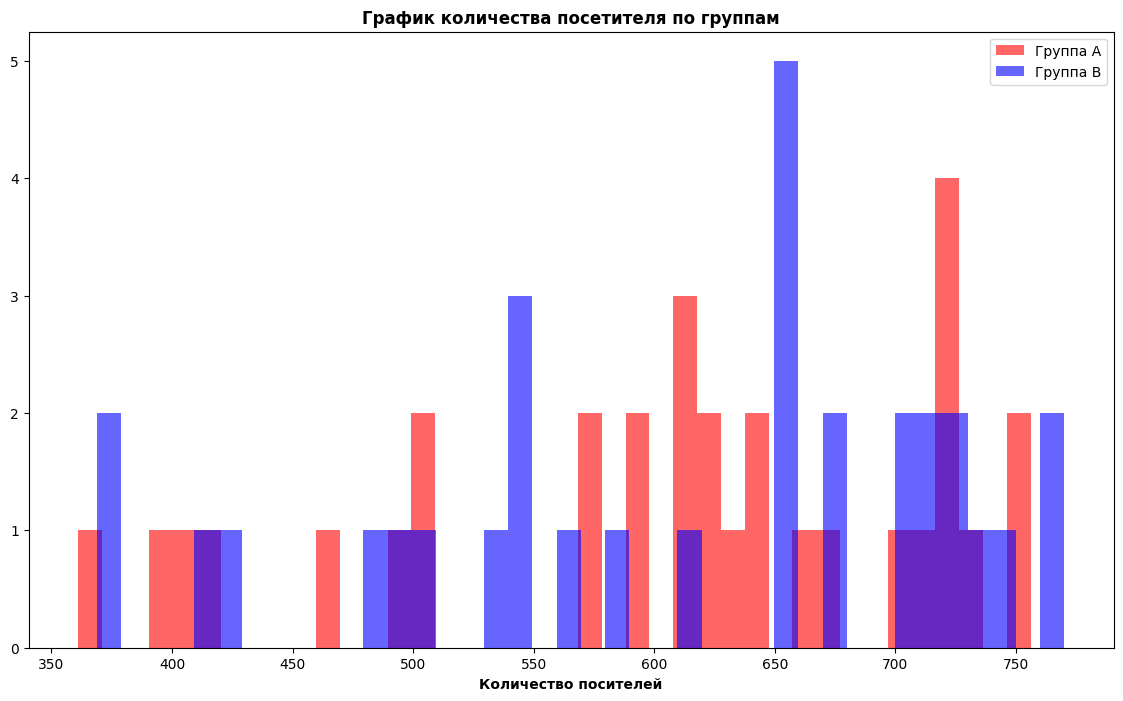

In [15]:
plt.figure(figsize=(14,8))
plt.hist(visitors[visitors['group']=='A']['visitors'], 
         label='Группа A', 
         bins = 40, 
         color='r',  
         alpha=0.6)
plt.hist(visitors[visitors['group']=='B']['visitors'], 
         label='Группа B', 
         bins = 40, 
         color='b', 
         alpha=0.6)
plt.title('График количества посетителя по группам', fontsize=12, fontweight="bold")
plt.xlabel('Количество посителей', fontsize=10, fontweight="bold")
plt.legend()
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Значимых различий между выборками нету, можно приступать к анализу А/B теста
</div>

## График камулятивной выручки по группам

In [16]:
orders.head() # Заказы

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [17]:
visitors.head() # Посетители

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [18]:
# Создание массива уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates().reset_index(drop=True)

In [19]:
# Получение агрегированных кумулятивных по дням данных о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transactionId' : 'nunique', 
          'visitorId' : 'nunique', 
          'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date', 'group']) \
    .reset_index(drop = True)

In [20]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,38,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,62,354874


In [21]:
# Получение агрегированных кумулятивных по дням данных о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'}), axis=1) \
                                        .sort_values(by=['date','group']) \
                                        .reset_index(drop = True)

In [22]:
visitorsAggregated.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845


In [23]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [24]:
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]

In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

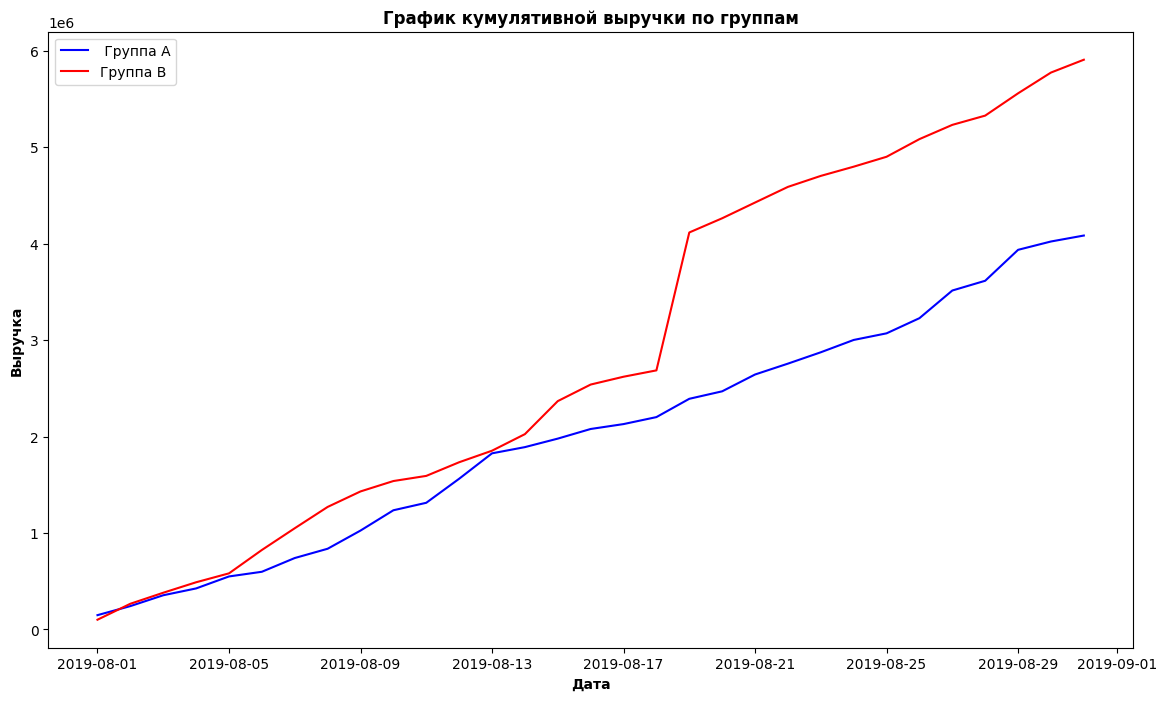

In [27]:
plt.figure(figsize=(14,8))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label=' Группа A', color='b')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B', color='r')
plt.title('График кумулятивной выручки по группам', fontsize=12, fontweight="bold")
plt.xlabel('Дата', fontsize=10, fontweight="bold")
plt.ylabel('Выручка', fontsize=10, fontweight="bold")
plt.legend()
plt.show()

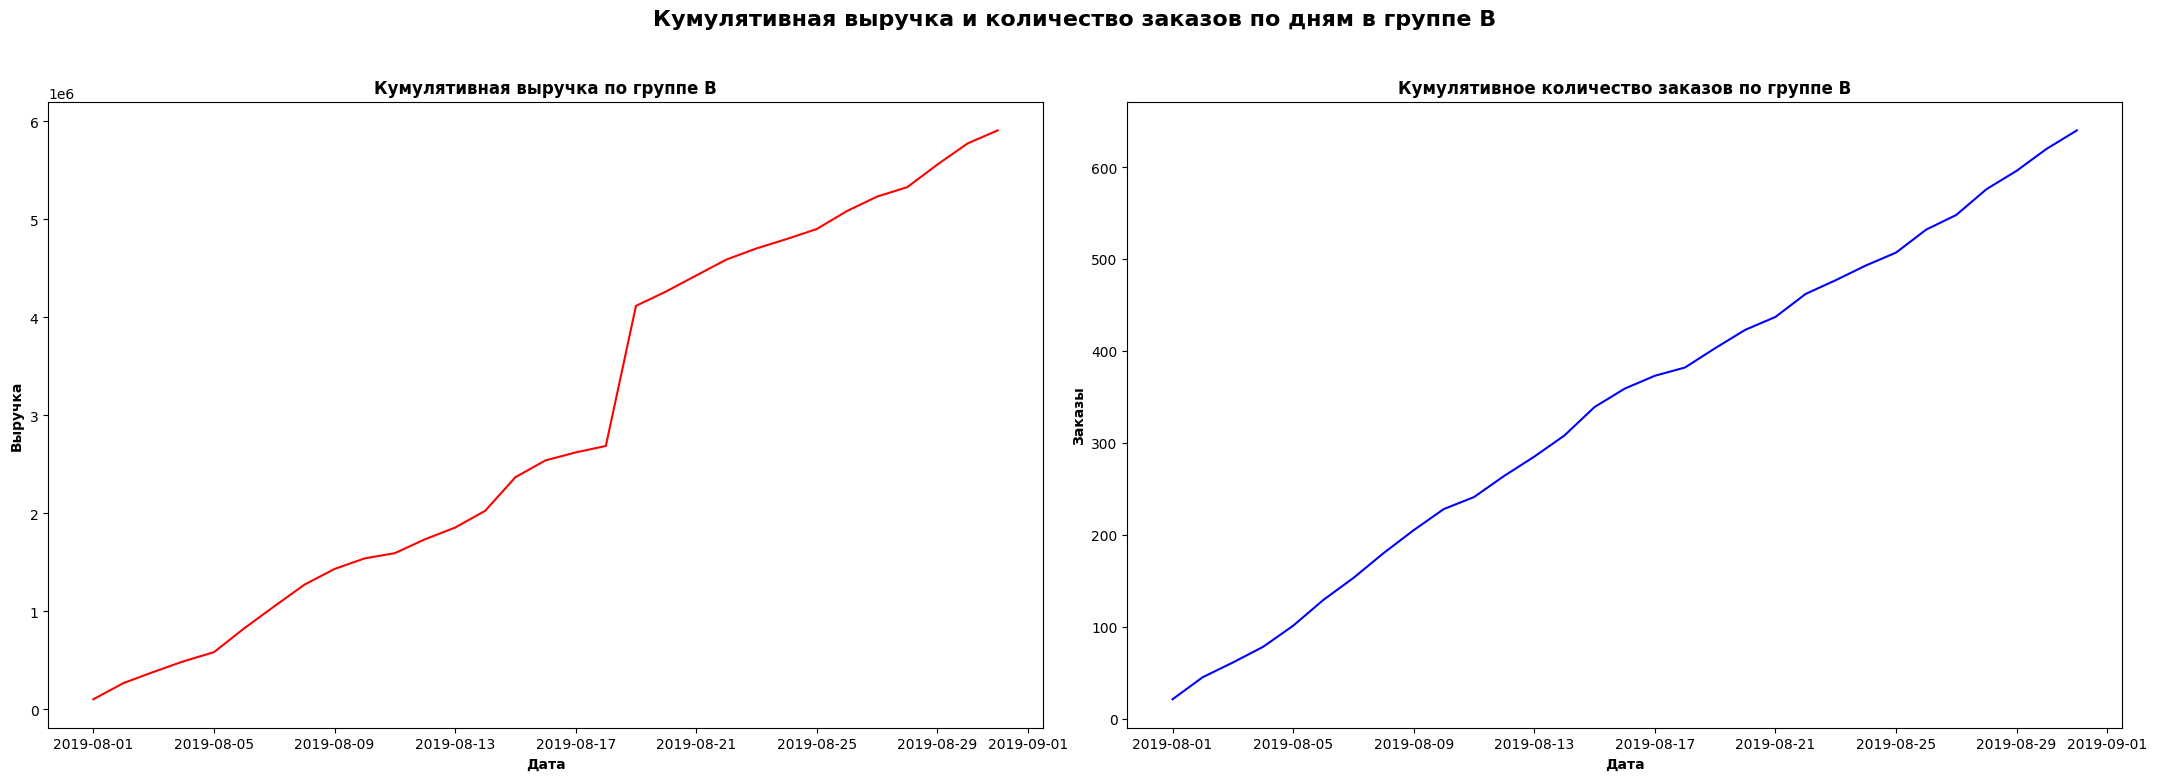

In [28]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
#Общее название
fig.suptitle('Кумулятивная выручка и количество заказов по дням в группе В', fontsize=16, fontweight="bold")
fig.tight_layout(pad=3.0)

ax0.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], 
         label='Группа B', 
         color='r' 
         )
ax0.set_title('Кумулятивная выручка по группе В', fontsize=12, fontweight="bold") 
ax0.set_xlabel('Дата', fontsize=10, fontweight="bold")
ax0.set_ylabel('Выручка', fontsize=10, fontweight="bold")


ax1.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders'], 
         label='Группа B', 
         color='b' 
        )
ax1.set_title('Кумулятивное количество заказов по группе В', fontsize=12, fontweight="bold")
ax1.set_xlabel('Дата', fontsize=10, fontweight="bold")
ax1.set_ylabel('Заказы', fontsize=10, fontweight="bold")
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   
    
- По графику наблюдается увеличение выручки ообоих групп, но группа `В` показвает лучший результат на протяжении всего срока тестирования.
- Всплеска заказов у группы `B` на графике не видно, но есть резкий скачок выручки с 18 по 19 августа 2019г, скорее всего появление дорогого заказа в выборке.
- Группа `А` показывает стабильный рост на протяжении срока тестирования.
</div>

## График кумулятивного среднего чека по группам

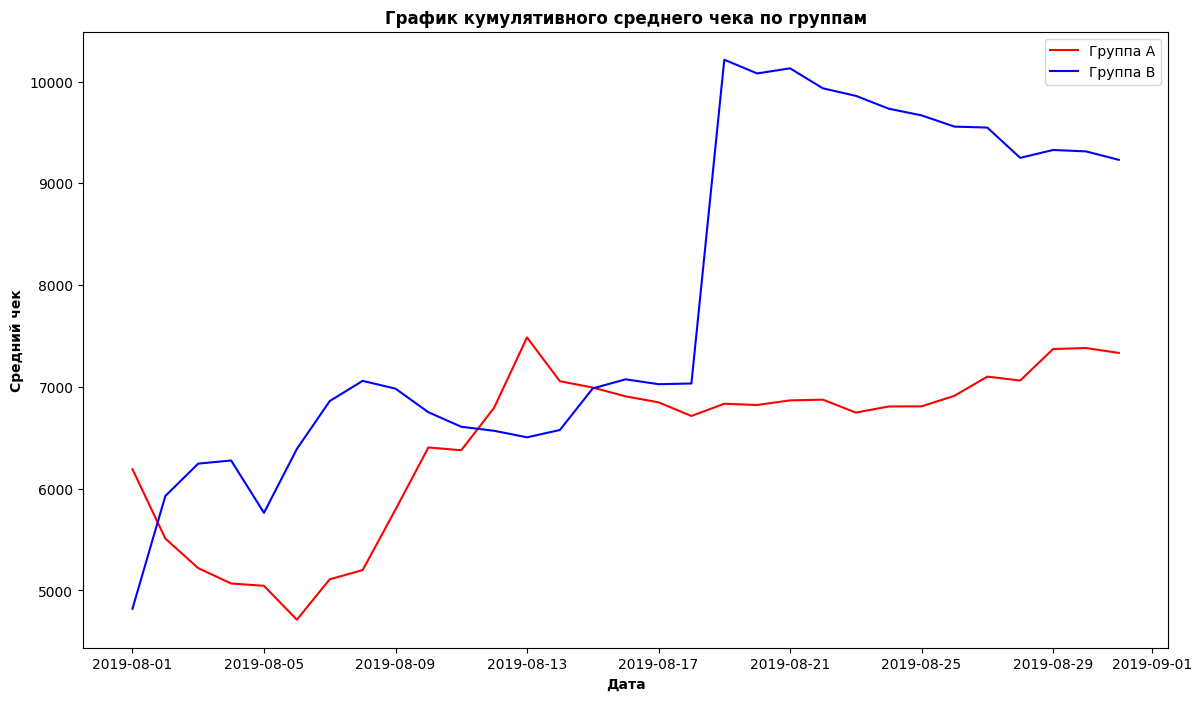

In [29]:
plt.figure(figsize=(14,8)) #Размер
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='Группа A', color='r',)
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='Группа B', color='b',)
plt.title('График кумулятивного среднего чека по группам', fontsize=12, fontweight="bold")
plt.xlabel('Дата', fontsize=10, fontweight="bold")
plt.ylabel('Средний чек', fontsize=10, fontweight="bold")
plt.legend()
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Видно, что средний чек группы `В` имеет резкий скачок с 18 на 19 число, скорее всего попал крупный заказ, средний чек группы `A` имеет падение 6 августа и скачок 13 августа, после стал равномерным ближе к концу теста.
</div>

## График относительного изменения кумулятивного среднего чека группы B к группе A

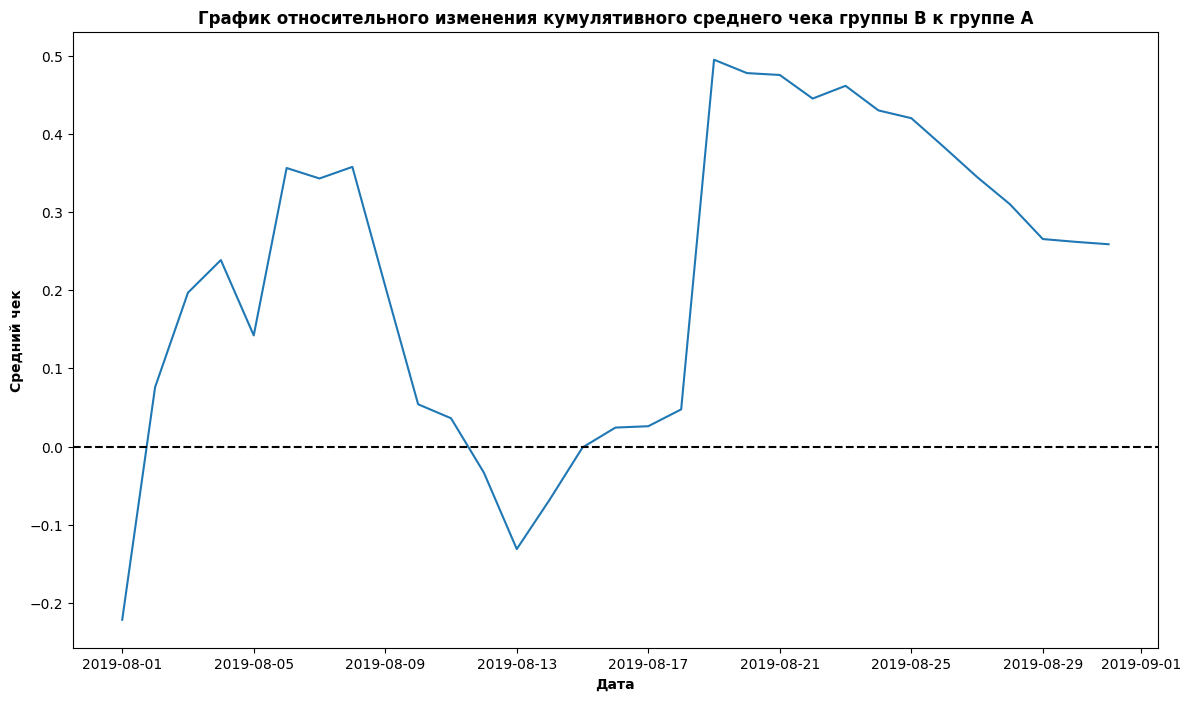

In [30]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(14,8)) #Размер
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1 
         )
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', 
          fontsize=12, 
          fontweight="bold")
plt.xlabel('Дата', fontsize=10, fontweight="bold")
plt.ylabel('Средний чек', fontsize=10, fontweight="bold")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Имеются резкие скачки между чеками, результаты менялись в несколько дат: 6 августа, падение 11 августа, особенно большое различие наблюдается при скачке с 18 по 19 августа 2019г.
</div>

## График кумулятивного среднего количества заказов на посетителя по группам

In [31]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [32]:
cumulativeData['conversion'] = round(cumulativeData['orders'] / cumulativeData['visitors'], 3)

In [33]:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

In [34]:
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

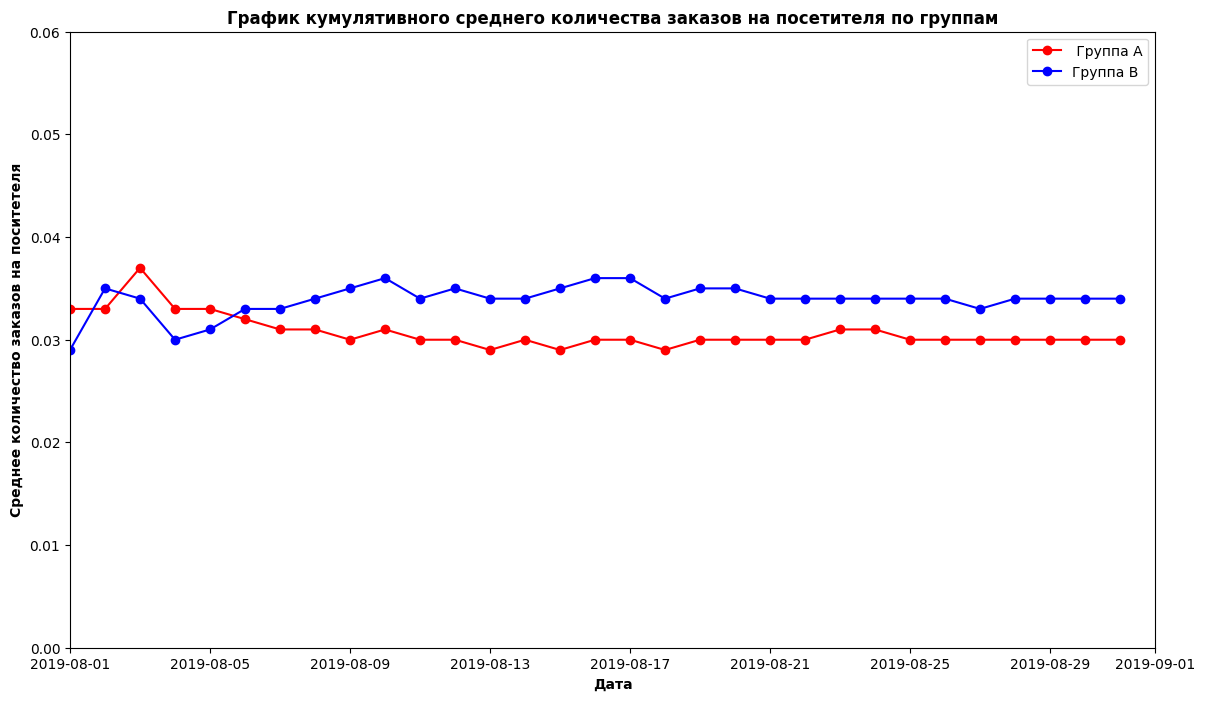

In [35]:
plt.figure(figsize=(14,8)) #Размер
# Группа А
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], 
         label=' Группа A', 
         marker = 'o', 
         color='r')
# Группа В
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], 
         label='Группа B', 
         marker = 'o',
         color='b')
# Название
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', 
          fontsize=12, 
          fontweight="bold")
plt.xlabel('Дата', fontsize=10, fontweight="bold")
plt.ylabel('Среднее количество заказов на поситетеля', fontsize=10, fontweight="bold")

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.06])
plt.legend()
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Группы колеблются вокруг одного значения, с самого начала теста группа `A` имела большее камулятивное количество заказов, но в последствии группа `B` оказалась выше и зафиксировалась.
    </div>

## График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

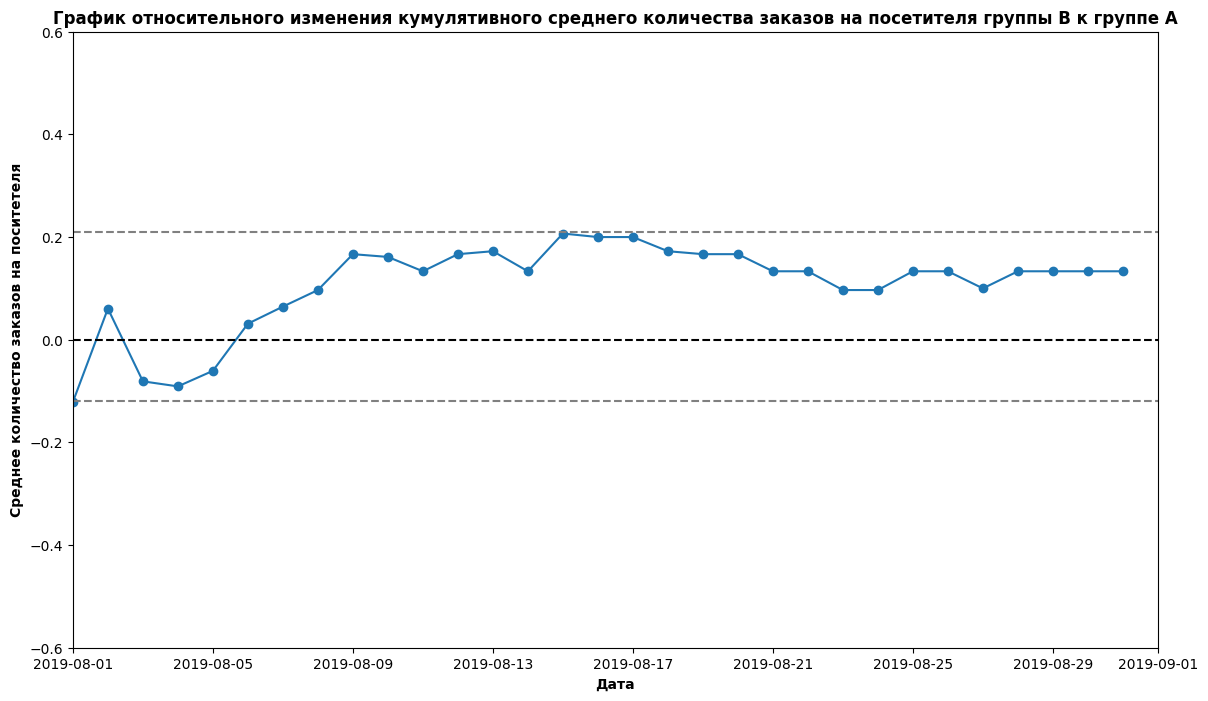

In [67]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']] \
    .merge(cumulativeDataB[['date','conversion']], 
           left_on='date', 
           right_on='date', 
           how='left', 
           suffixes=['A', 'B'])
plt.figure(figsize=(14,8)) #Размер
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A",
        marker = 'o')

# Название
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A', 
          fontsize=12, 
          fontweight="bold")
plt.xlabel('Дата', fontsize=10, fontweight="bold")
plt.ylabel('Среднее количество заказов на поситетеля', fontsize=10, fontweight="bold")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.12, color='grey', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.6, 0.6])
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Группа `B` начала лидировать после 7 августа, самая высокая точка около 21% относительно группы `A`
 </div>

## График количества заказов по пользователям

In [37]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [38]:
ordersByUsers = orders.groupby('visitorId', as_index=False) \
    .agg({'transactionId':'nunique'}) \
    .sort_values(by='transactionId', ascending=False)

In [39]:
info_data_frame(ordersByUsers)

------Информация о DataFrame------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 1023 to 1030
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   visitorId      1031 non-null   int64
 1   transactionId  1031 non-null   int64
dtypes: int64(2)
memory usage: 24.2 KB


None

None

'-------------------------'

'Вывод первых 5 строчек:'

,visitorId,transactionId
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


'Число строк : 1031'

'-------------------------'

'Число столбцов : 2'

'-------------------------'

'Количество дубликатов = 0'

'-------------------------'

'Пропущенные значения:'

visitorId        0
transactionId    0
dtype: int64

'-------------------------'

'Процент пропусков от всего DataFrame:'

visitorId        0.0%
transactionId    0.0%
dtype: object

In [40]:
x_values = pd.Series(range(0, len(ordersByUsers)))

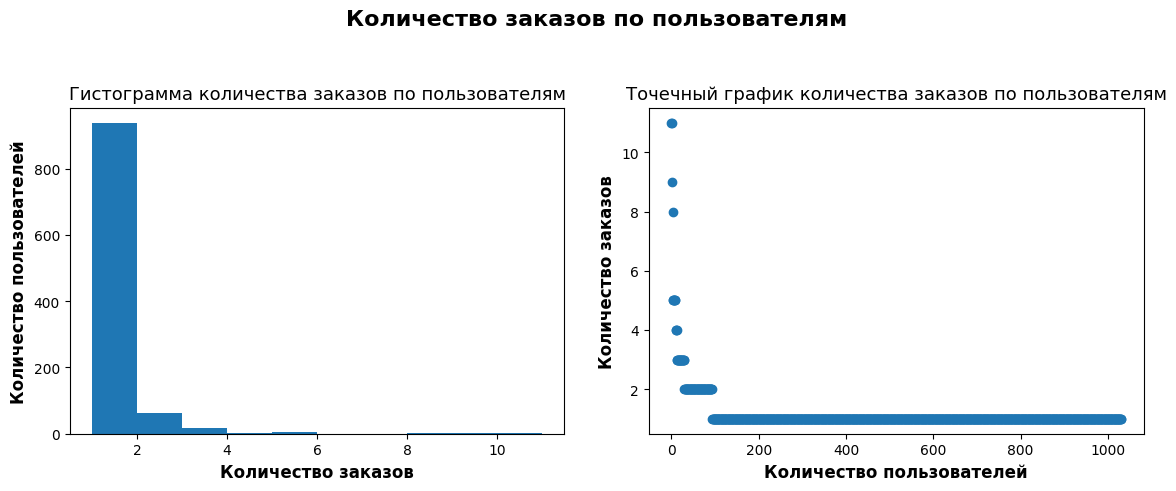

In [41]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
#Общее название
fig.suptitle('Количество заказов по пользователям', fontsize=16, fontweight="bold") #Титульное название
fig.tight_layout(pad=3.0) #Отступ от титульного названия

ax0.hist(ordersByUsers['transactionId'])
ax0.set_title('Гистограмма количества заказов по пользователям', fontsize=13) #Название
ax0.set_xlabel('Количество заказов', fontsize=12, fontweight="bold")
ax0.set_ylabel('Количество пользователей', fontsize=12, fontweight="bold")
ax1.scatter(x_values, ordersByUsers['transactionId'])
ax1.set_title('Точечный график количества заказов по пользователям', fontsize=13)
ax1.set_xlabel('Количество пользователей', fontsize=12, fontweight="bold")
ax1.set_ylabel('Количество заказов', fontsize=12, fontweight="bold")
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Графики показывают, что большинство пользователей не совершают заказы более двух раз.
 </div>

## Подсчёт 95-й и 99-й количества заказов на пользователя

In [42]:
percentile = np.percentile(ordersByUsers['transactionId'],[95, 99])

In [43]:
display(f"Не более 5% пользователей заказывают {percentile[0].astype(int)} заказа")
display(f"Не более 1% пользователей заказывают {percentile[1].astype(int)} заказа")

'Не более 5% пользователей заказывают 2 заказа'

'Не более 1% пользователей заказывают 4 заказа'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Подсчёт перцентилей подтверждают теорио о том, что больше 2х заказов делает малое количество пользователей. Пользователей, заказавших больше 3-х заказов примем за аномальных.
 </div>

## График стоимости заказов

In [44]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [45]:
xx_values = pd.Series(range(0, len(orders['revenue'])))

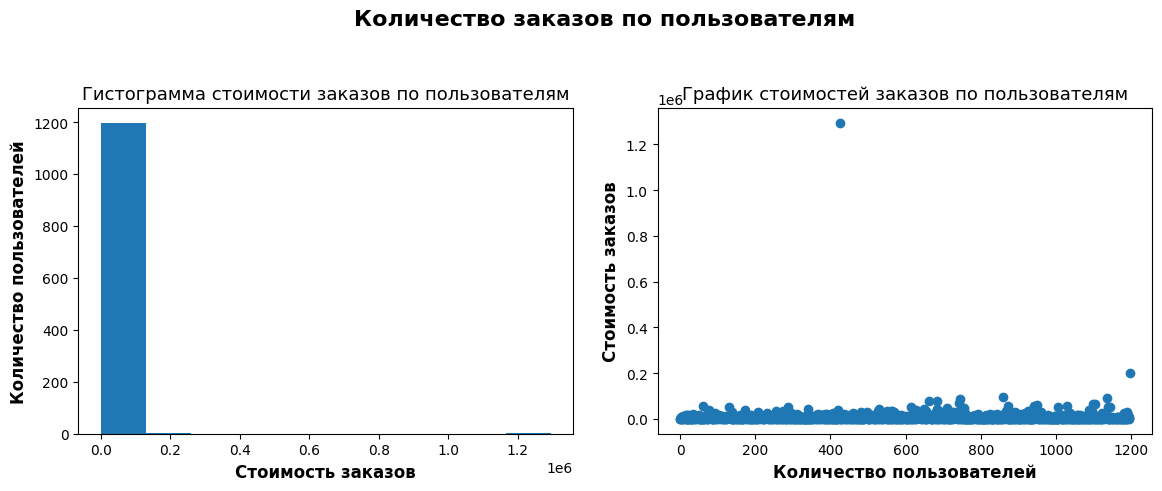

In [46]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
#Общее название
fig.suptitle('Количество заказов по пользователям', fontsize=16, fontweight="bold") #Титульное название
fig.tight_layout(pad=3.0) #Отступ от титульного названия

ax0.hist(orders['revenue'])
ax0.set_title('Гистограмма стоимости заказов по пользователям', fontsize=13) #Название
ax0.set_xlabel('Стоимость заказов', fontsize=12, fontweight="bold")
ax0.set_ylabel('Количество пользователей', fontsize=12, fontweight="bold")

ax1.scatter(xx_values, orders['revenue'])
ax1.set_title('График стоимостей заказов по пользователям', fontsize=13)
ax1.set_xlabel('Количество пользователей', fontsize=12, fontweight="bold")
ax1.set_ylabel('Стоимость заказов', fontsize=12, fontweight="bold")
plt.show()

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Два заказа стоимостью 200000 и больше миллиона явно выбиваются из общего количества заказов.

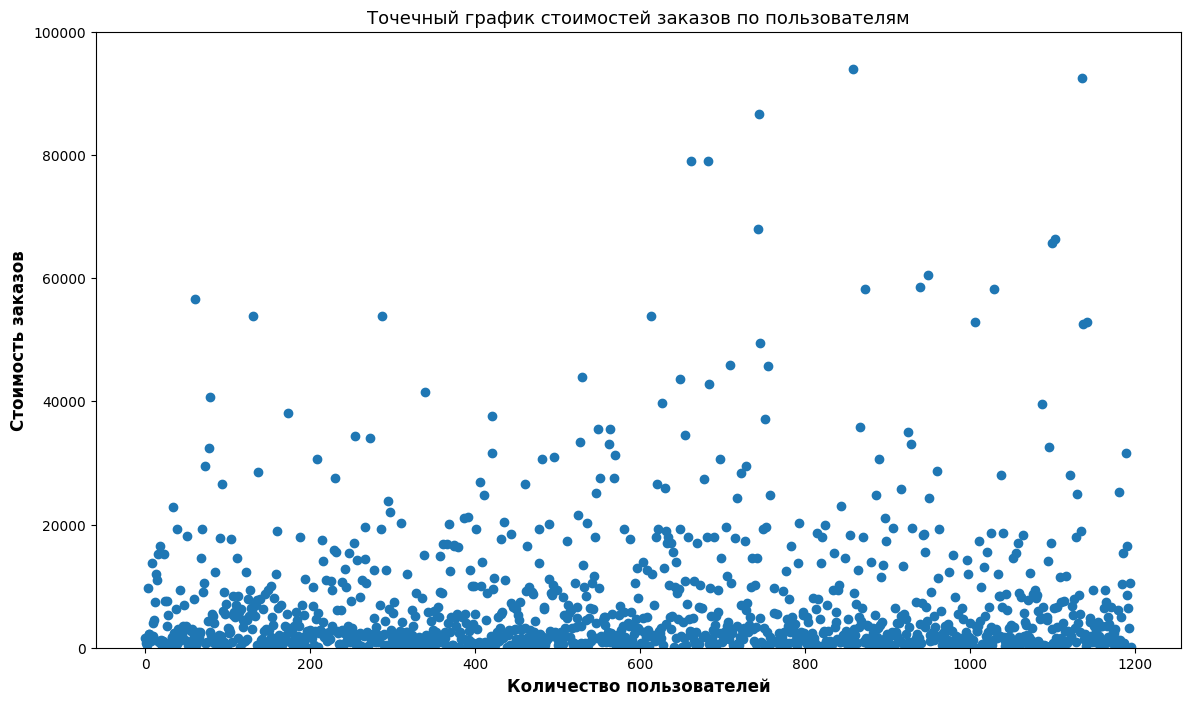

In [47]:
# Размер графика
plt.figure(figsize=(14,8))

plt.scatter(xx_values, orders['revenue'])
# Максимум по оси y
plt.ylim(0, 100000)

plt.title('Точечный график стоимостей заказов по пользователям', fontsize=13) 
plt.ylabel('Стоимость заказов', fontsize=12, fontweight="bold") 
plt.xlabel('Количество пользователей', fontsize=12, fontweight="bold") 

plt.show()  

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Большинство заказов не превышают стоимость 100000. Основное количество заказов лежит в пределах 20000.
 </div>

## Подсчёт 95-й и 99-й перцентили стоимости заказов

In [48]:
percentile_revenue = np.percentile(orders['revenue'],[95, 99])

In [49]:
display(f"Не более 5% пользователей заказывают на сумму {percentile_revenue[0].astype(int)}")
display(f"Не более 1% пользователей заказывают на сумму {percentile_revenue[1].astype(int)}")

'Не более 5% пользователей заказывают на сумму 28000'

'Не более 1% пользователей заказывают на сумму 58233'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">
    
Подсчёт перцентилей подтверждают теорио о том, что на сумму больше 28000 заказывают довольно редко. отфильтруем пользователей, заказавших на сумму выше 30000.
 </div>

## Подсчёт статистической значимости различий в среднем количестве заказов на поситителя между группами

In [50]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [51]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [52]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(0, 
                  index=np.arange
                  (visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
                  ),
                  name='orders'
                 )
    ],
    axis=0)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(0, 
                  index=np.arange
                  (visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
                  ),
                  name='orders'
                 )
    ],
    axis=0)

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

    Данные для расчёта статистической значимости готовы 
- `sampleA` - выборка, где каждый элемент число заказов определённого пользователя, в том числе ноль группы `А`   
- `sampleB` - выборка, где каждый элемент число заказов определённого пользователя, в том числе ноль группы `B`
- Статистическая значимость - 0.05
- **Н0 - Статистических различий между группами нет**.
- **Н1 - Статистические различия между группами есть**.
- Для расчёта статистической значимости между группами будет применяться тест Манна-Уитни.
 </div>

In [53]:
# Тест Манна-Уитни
results = st.mannwhitneyu(sampleA, sampleB)[1]

In [54]:
display("pvalue: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
alpha = 0.05
if results < alpha:
    display('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    display('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
display("Средняя конверсия в группе А: {0:.1%}:".format(sampleA.mean()))
display("Средняя конверсия в группе B: {0:.1%}:".format(sampleB.mean())) 
display("Относительное различие между группами: {0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

'pvalue: 0.017'

'Отвергаем нулевую гипотезу: разница статистически значима'

'Средняя конверсия в группе А: 3.0%:'

'Средняя конверсия в группе B: 3.4%:'

'Относительное различие между группами: 13.8%'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

- `pvalue` меньше `alpha` - статистические значимые различия между группами есть.
- Отношение группы `В` к группе `A` относительный прирост 13.8% является не плохим показателем.
      
 </div>

## Подсчёт статистической значимости различий в среднем чеке заказа

In [55]:
results_1 = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

In [56]:
display("pvalue: {0:.3f}".format(results_1))

if results_1 < alpha:
    display('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    display('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
display("Средний чек в группе А: {0:.1f}:".format(orders[orders['group']=='A']['revenue'].mean()))
display("Средний чек в группе B: {0:.1f}:".format(orders[orders['group']=='B']['revenue'].mean()))     
display("Относительное различие между группами: {0:.1%}".format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))    

'pvalue: 0.729'

'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

'Средний чек в группе А: 7333.6:'

'Средний чек в группе B: 9230.9:'

'Относительное различие между группами: 25.9%'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

- `pvalue` больше `alpha` - статистически значимых различий между группами нет.
- Отношение группы `В` к группе `A` относительное различие среднего чека между группами - 26%, скорее всего это наличие аномальных заказов.
      
 </div>

## Подсчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

- 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказа, примем за аномальных пользователей тех, кто совершил больше 3-х заказов
- 95-й и 99-й перцентили средних чеков равны 28000 и 58233, примем за аномальных пользователей тех, кто совершил покупку на сумму свыше 30000.
      
 </div>

In [57]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0). \
    drop_duplicates(). \
    sort_values()

In [58]:
abnormalUsers.isna().sum() # Пропуски

0

In [59]:
abnormalUsers.duplicated().sum() # Дубликаты

0

In [60]:
# Очищенные данные группы А
ampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Очищенные данные группы B
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

    Данные для расчёта статистической значимости готовы 
- `ampleAFiltered` - выборка, где сохранены данные о заказах группы `А` в котрую не включены аномальные пользователи.  
- `sampleBFiltered` - выборка, где сохранены данные о заказах группы `В` в котрую не включены аномальные пользователи.
- Статистическая значимость - 0.05
- **Н0 - Статистических различий между группами нет**.
- **Н1 - Статистические различия между группами есть**.  
 </div>

In [61]:
results_2 = st.mannwhitneyu(ampleAFiltered, sampleBFiltered)[1]

In [62]:
display("pvalue: {0:.3f}".format(st.mannwhitneyu(ampleAFiltered, sampleBFiltered)[1]))

if results_2 < alpha:
    display('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    display('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
display("Средняя конверсия в группе А: {0:.1%}:".format(ampleAFiltered.mean()))
display("Средняя конверсия в группе B: {0:.1%}:".format(sampleBFiltered.mean())) 
display("Относительное различие между группами: {0:.1%}".format(sampleBFiltered.mean() / ampleAFiltered.mean() - 1))

'pvalue: 0.018'

'Отвергаем нулевую гипотезу: разница статистически значима'

'Средняя конверсия в группе А: 2.7%:'

'Средняя конверсия в группе B: 3.1%:'

'Относительное различие между группами: 14.8%'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

- `pvalue` увеличился с 0.017 до 0.018, но это не позволяет принять нулевую гипотезу о том, что разницы нет, конверсии групп разные.
- Статистическая значимость достигнута, группа `B` значительно лучше группы `А`.
- Относительный средний прирост группы `В` по сравнению с группой А стал выше на 1%.
      
 </div>

## Подсчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

In [63]:
#Очищенные данные группы А
revenue_1 = orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']

In [64]:
#Очищенные данные группы B
revenue_2 = orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']

In [65]:
results_3 = st.mannwhitneyu(revenue_1, revenue_2)[1]

In [66]:
display("pvalue: {0:.3f}".format(results_3))

if results_3 < alpha:
    display('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    display('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
display("Средний чек в группе А: {0:.1f}:".format(revenue_1.mean()))
display("Средний чек в группе B: {0:.1f}:".format(revenue_2.mean()))     
display("Относительное различие между группами: {0:.1%}".format(revenue_2.mean() / revenue_1.mean() - 1))    

'pvalue: 0.958'

'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

'Средний чек в группе А: 5333.3:'

'Средний чек в группе B: 5228.2:'

'Относительное различие между группами: -2.0%'

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">

- `pvalue` увеличился с 0.729 до 0.958 и все так же больше `alpha`, принимаем нулевую гипотезу о равенстве групп.
- Статистическая значимость не достигнута, средние чеки обоих групп почти выровнялись после удаления аномальных пользователей.
- Относительный средний прирост группы `В`, по сравнению с группой `A`снизился с 26% до почти нулевого.      
 </div>

# Решение о продолжении А/B теста

<div style="color: #000000; border-left: 3px solid #DCDCDC; border-right: 3px solid #DCDCDC; margin-left: 20px; padding-left: 10px">   

**Общий вывод:** 
1. Открыты 3 DataFrame hypothesis, orders, visitors, дубликаты и пропуски не обнаружены, столбьцы приведены к нужным типам и регистрам.
2. Применился фреймоворк `ICE` и `RICE`для приоритизации гипотез, после применения `RICE` приоритеты поменялись.
3. Построены графики, подсчитаны 95-й и 99-й перцентили количества заказов на пользователя и стоимости заказов.
4. Выбрана граница для определения аномальных заказов и удалены аномальные пользователи, совершившие более 3 заказов на сумму более 30000.
5. Есть статистически значимые различия по количеству заказов между группами как по «сырым» данным так и по очищенным.
6. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
7. График относительного изменения кумулятивного среднего количества заказов на посетителя группы `B` к группе `A` показывает, что результаты группы `B` лучше группы `А`, но тенденции к улучшению нет, так как данные зафиксировались.
8. График относительного изменения кумулятивного среднего чека группы `B` к группе `A` показывает колебания, а так же улучшения сегмента `В` по сравнению с сегментом `А`, а так же показывает снижение в последние даты, но если сравнить данные по среднему чеку после удаления аномальных пользователей то средний чек группы `B`, стал меньше по отношению к группе `A`.
9. **На основании обнаруженных фактов, тест следует остановить и признать успешным, статистическая значимость в среднем количестве заказов на посетителя между группами достигнута, относительный прирост конверсии группы `В` по сравнению с группой `А` 14.8%.**
</div>